**Den vildsinte kan få köra den här notebooken uppifrån och ned för att se vad resultaten blir...**

# SUPPORT VECTOR MACHINE, SVM

In its essence, SVM is a classification method which seperates classes by finding a hyperplane which divides them in the metric space.

<div>
    <img src="misc/svm-linear-seperation.png" width="300"/>
</div>

As one quickly discovers, such a hyperplane is often never possible when the data overlaps, or there's infinite possibilities when it doesn't. To solve this, SVMs inflicts a margin to its hyperplane and allows for missclassifications on that margin. With this, a loss function for points $x_i$ on that margin is minimized to find the hyperplane. The "support vector" comes from the points $x_i$, i.e. vectors, which lie on the edge of the margin. 

<div>
    <img src="misc/SVM_margin.png" width="300"/>
</div>

## Kernels
Since our hyperplane is linear it will often not be a good enough fit for the data. This problem is solved using functions which transforms space of the data set $X$ into a non-linear mapping - then the SVM will act as a non-linear dividor in the original space, but still beeing linear in the transformed. 

<div>
    <img src="misc/kernel.png" width="450"/>
</div>

The transformation functions could in theory be anything, but due a _simple_ (read: _difficult but elegant_) cumputational caviat called the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method), the ones used are **kernel functions**. These are a subset of transformations which vastly outperforms their non-kernel peers in computational and mememory needs for classification. 

## Comment on Parameters
Although we fit the hyperplane to minimize an objective loss function (this is based on summing the distance to the hyperplane to missclassified points are), SVMs will often also inflict a regulization parameter $C$ which sets a maximum distance a point can be missclassified. A small C will a allow for a larger margin, allowing for less missclassifications and vise versa. 


## Outline
1. Preprocessing
2. Model Exploration
    1. No kernel
    3. RBF
    4. Polynomial
3. Conclusion

## Preprocessing

We import the data and necessary libraries

In [1]:
# External
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Internal
from utils.import_data import importData
from utils.model_tester import ModelTester
import utils.nicer_plots

In [2]:
# The name of the files to be imported
file_data = "data2.csv"
file_labels = "labels2.csv"
directory = "\data\\"

# Import the data
data, labels = importData(file_data, file_labels, directory)

Number of samples:    102400
Number of features:   3851


# Model exploration

In [4]:
from sklearn.svm import SVC # support vector classifier
from warnings import filterwarnings
filterwarnings('ignore') # :)
mt = ModelTester(data, labels, SVC) # initiate testing environment for our models

## A. No Kernel

We simply test to see if we can use standard (linear) SVM to find a hyperplane which seperates the classes. 

There is no "good" way to find $C$. So we do it by brute-force with testing on future iterations (of CMA-ES). 

### Finding the best hyperparameters

In [4]:
parameters = {'C':[0.0001,0.001,0.01,0.1,0.5,1,5,10],
              'kernel':['linear'],
              'max_iter':[10**2],
              'probability':[True]} # is set to True to avoid a bug in the code :) the (generated) probabilities are not used.

# running the  brute force function
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 1, score = "balanced_accuracy", update_parameters = True, sampling = 'under', **parameters)


   Ranking        C  kernel      max_iter  probability      balanced_accuracy    Standard deviation
---------  -------  --------  ----------  -------------  -------------------  --------------------
        1   0.001   linear           100  True                      0.501443                     0
        2   0.01    linear           100  True                      0.499997                     0
        3   0.1     linear           100  True                      0.499997                     0
        4   0.5     linear           100  True                      0.499997                     0
        5   1       linear           100  True                      0.499997                     0
        6   5       linear           100  True                      0.499997                     0
        7  10       linear           100  True                      0.499997                     0
        8   0.0001  linear           100  True                      0.496752                     0


**Note** that the standard deviation is equal to zero since every model was trained only once. So we have a high risk of the best results stemming from chance.

Our model is fitted to the 'best' parameters, i.e. which had the highest 'balanced_accuracy' score (we can't choose AUC as score  since SVMs don't yield probabilities). Unfortunately, at an early stage we don't se great results other than $C=0.001$ seems to performe best. 

Let's take a closer look at the result by training a few more times to see prediction interval and a bit more

### Evaluating model
Using the best parameters, we run the model a few times to get prediction intervals on our results.

Training times:


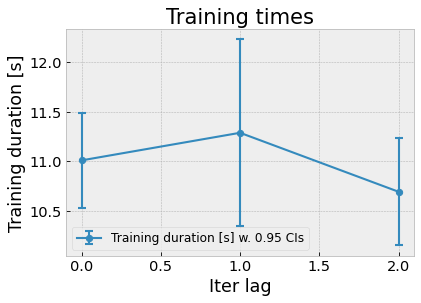

Weighted accuracies:


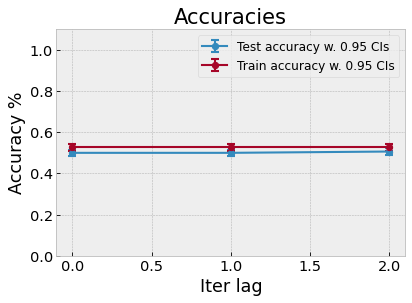

Test accuracies: [0.49947656 0.4995111  0.50583889]
Confusion matrices:


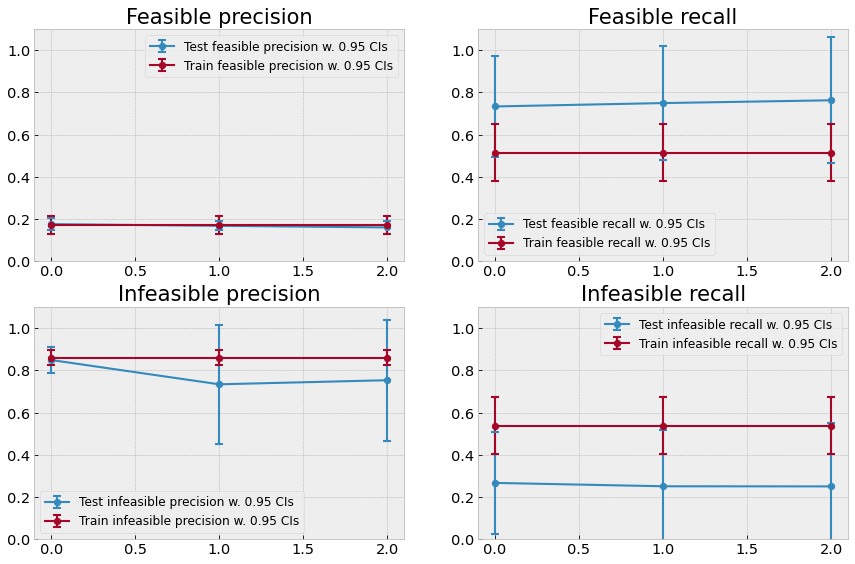

Percentage infeasible on test and train data:


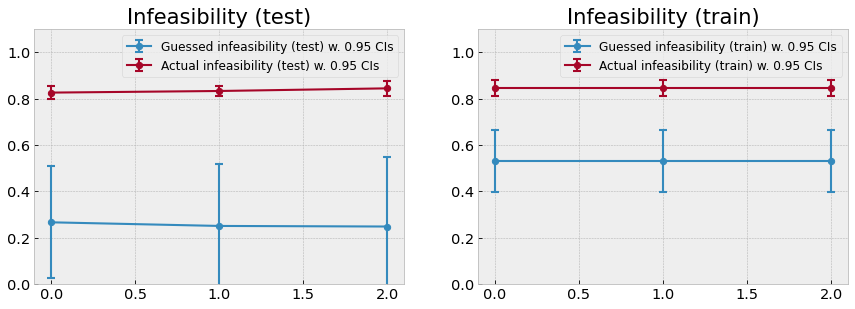

In [5]:
# run the training again on the best parameter! Now a few more time to get better estimates
mt.training_loop(sampling = 'under', printing = False)
mt.plot_graphs(AUC = False) # Can't do AUC since no (true) probabilities are generated in SVMs

In [6]:
mt.print_essentials()

variable                             average    std  95.0% CI          min     max
---------------------------------  ---------  -----  --------------  -----  ------
weighted accuracy [%]                  49.95   1.28  (49.03, 50.87)  47.43   52.18
duration [s]                           11.01   0.42  (10.71, 11.31)  10.18   11.75
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)  77.25   85.45
infeasible_guessed_percentage [%]      26.57  21.34  (11.3, 41.83)    0.05   64.21
feasible_recall [%]                    73.33  21.23  (58.14, 88.51)  37.3   100
feasible_precision [%]                 17.45   2.6   (15.59, 19.31)  13.69   22.77
infeasible_recall [%]                  26.57  21.39  (11.26, 41.87)   0.06   64.49
infeasible_precision [%]               84.92   5.59  (80.92, 88.93)  77.66  100
AUC of ROC                              0.5    0.02  (0.48, 0.52)     0.47    0.54


## B. RBF Kernel
The _radial basis function_ is works in practice as a weighted version of [k-nearest neigbhor](https://github.com/KodAgge/Feasibility-Prediction/blob/main/code/04-Nearest%20Neighbor.ipynb). That is, neighbors close (in the euclidian sense) to the point $x_i$ has a greater impact on the classification of that point than points further away. 

Here another parameter gamma, $\gamma$, determines the influence of neighbors in proportion to their distance.
A high value on $\gamma$ will focus points close to the testing set and a lower $\gamma$ will consider points in a wider distance. A great visual example and the interlink with $C$ can be found [here](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

In [5]:
parameters = {'C':[0.001,0.005,0.01,0.05,.1,0.5,1], # relaxation paramater
              'gamma':[0.001,0.01,0.05,.1,0.5,1], # weight
              'kernel':['rbf'],
              'max_iter':[10**2],
              'probability':[True]}

# running the brute force function
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 1, score = "balanced_accuracy", update_parameters = True, sampling = 'under', **parameters)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [49:11<00:00, 70.29s/it]


   Ranking      C    gamma  kernel      max_iter  probability      balanced_accuracy    Standard deviation
---------  -----  -------  --------  ----------  -------------  -------------------  --------------------
        1  0.5      0.001  rbf              100  True                      0.519138                     0
        2  0.5      0.01   rbf              100  True                      0.505214                     0
        3  0.01     0.001  rbf              100  True                      0.501784                     0
        4  1        0.01   rbf              100  True                      0.500606                     0
        5  0.001    0.001  rbf              100  True                      0.500045                     0
        6  0.5      1      rbf              100  True                      0.5                          0
        7  0.5      0.5    rbf              100  True                      0.5                          0
        8  0.1      1      rbf              

**Note** that the standard deviation is equal to zero since every model was trained only once. So we have a high risk of the best results stemming from chance.

The best parameters are saved in the model. Let's take a closer look at the result

Weighted accuracies:


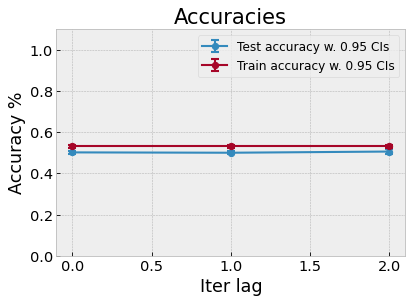

Test accuracies: [0.50170347 0.49999175 0.50575782]
Confusion matrices:


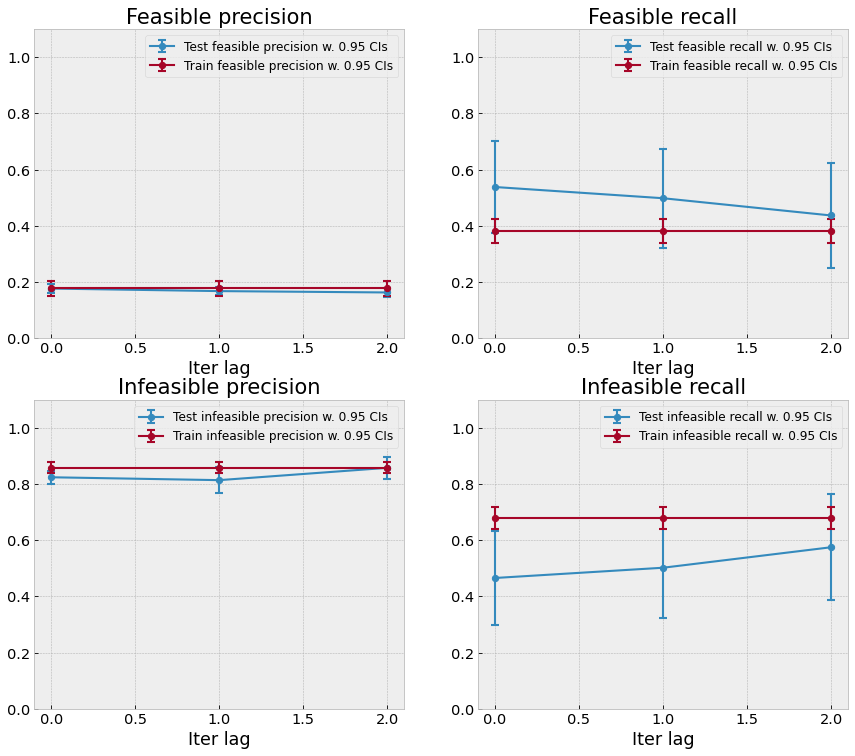

Percentage infeasible on test and train data:


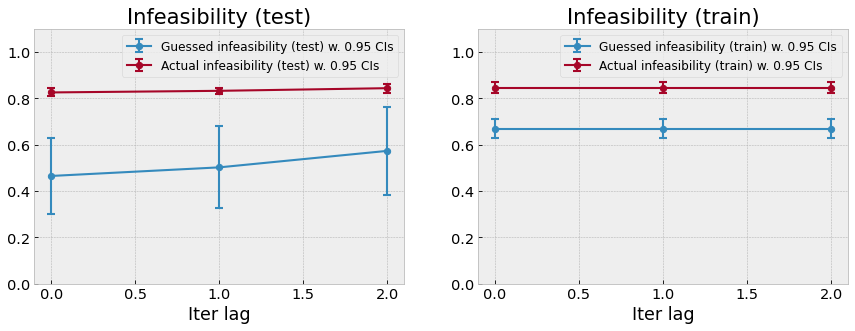

In [6]:
# run the training again on the best parameter! Now a few more time to get better estimates
mt.training_loop(sampling = 'under')
mt.plot_graphs(AUC = False)

In [7]:
mt.print_essentials()

variable                             average    std  95.0% CI          min    max
---------------------------------  ---------  -----  --------------  -----  -----
weighted accuracy [%]                  50.17   1.2   (49.31, 51.03)  47.82  51.91
duration [s]                           51.69   0.13  (51.59, 51.78)  51.56  51.93
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)  77.25  85.45
infeasible_guessed_percentage [%]      46.5   23.08  (29.99, 63.02)   3.56  79.93
feasible_recall [%]                    53.79  22.77  (37.51, 70.08)  23.2   96.14
feasible_precision [%]                 17.63   2.35  (15.95, 19.31)  14.66  22.68
infeasible_recall [%]                  46.55  23.17  (29.97, 63.12)   3.48  80.51
infeasible_precision [%]               82.42   3.27  (80.08, 84.76)  75.34  85.9
AUC of ROC                              0.5    0.02  (0.48, 0.52)     0.46   0.54


## C. Polynomial

Lastly, we will also look at the polynomial kernel which essentially (_waves hands around_) maps the data into a higher feature space based on the polynomial indeterminate (i.e. binomial formula).
$$ K(x_i,x_j)=(x_i^Tx_j + r)^d$$

It's difficult to give a reason for this to be effectful. The essential argument is "not to leave any stone unturned". Otherwise we wouldn't be doing our, job _would we_?

In [8]:
parameters = {'C':[0.001,0.01,.1,0.5,1],
              'degree':[2,3], # d in model
              'coef0':[0,1], # r in model
              'kernel':['poly'],
              'max_iter':[2 * 10 ** 1],
              'probability':[True]}
              
# running the brute force function
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 10, score = "balanced_accuracy", update_parameters = True, sampling = 'over', **parameters)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [52:18<00:00, 156.90s/it]


   Ranking      C    degree    coef0  kernel      max_iter  probability      balanced_accuracy    Standard deviation
---------  -----  --------  -------  --------  ----------  -------------  -------------------  --------------------
        1  1             3        1  poly              20  True                      0.503392            0.00959943
        2  0.5           3        1  poly              20  True                      0.503392            0.00959943
        3  0.5           2        1  poly              20  True                      0.500947            0.0104726
        4  0.1           2        1  poly              20  True                      0.500043            0.0130425
        5  0.001         2        1  poly              20  True                      0.498378            0.0156412
        6  1             2        1  poly              20  True                      0.497747            0.00673376
        7  1             2        0  poly              20  True          

Weighted accuracies:


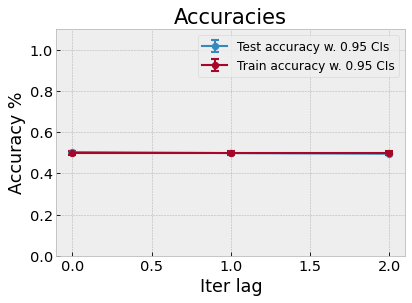

Test accuracies: [0.50339222 0.49825    0.49513359]
Confusion matrices:


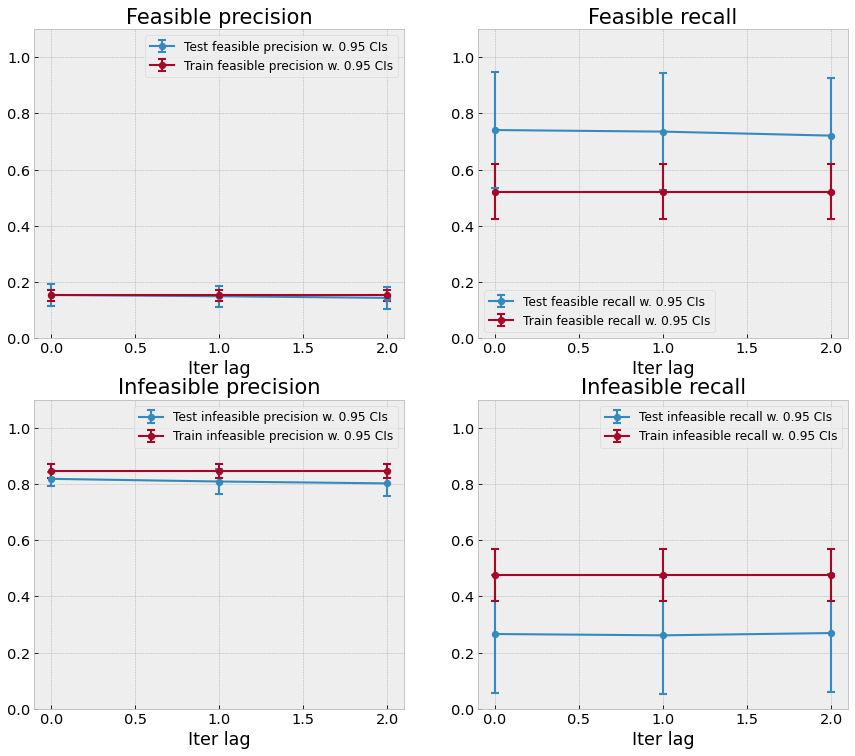

Percentage infeasible on test and train data:


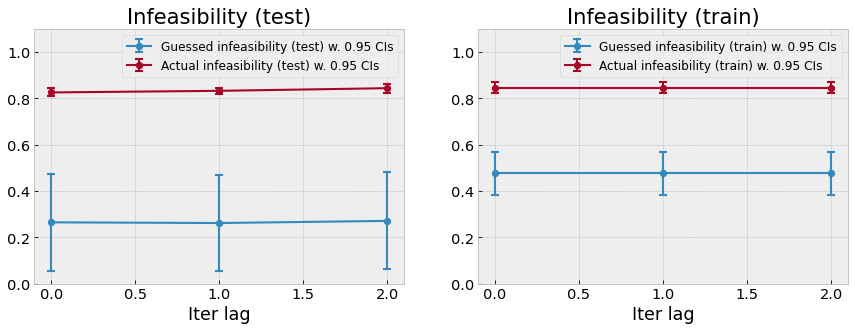

AUC:


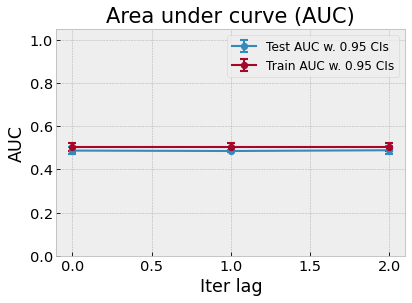

In [9]:
# run the training again on the best parameter! Now a few more time to get better estimates
mt.training_loop(sampling = 'over')
mt.plot_graphs()

In [10]:
mt.print_essentials()

variable                             average    std  95.0% CI          min     max
---------------------------------  ---------  -----  --------------  -----  ------
weighted accuracy [%]                  50.34   0.96  (49.65, 51.03)  48.69   51.96
duration [s]                           11.01   0.04  (10.99, 11.04)  10.98   11.09
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)  77.25   85.45
infeasible_guessed_percentage [%]      26.49  29.25  (5.56, 47.42)    0.59  100
feasible_recall [%]                    74.08  28.78  (53.49, 94.67)   0      99.35
feasible_precision [%]                 15.34   5.37  (11.5, 19.18)    0      19.77
infeasible_recall [%]                  26.59  29.37  (5.59, 47.6)     0.57  100
infeasible_precision [%]               81.86   3.44  (79.39, 84.32)  75.69   86.94
AUC of ROC                              0.49   0.02  (0.48, 0.5)      0.47    0.51


# Conclusion

After testing three different kernel setups with a wide range of parameters we can almost surely say that nothing worked. 

The result which tops out at 52% accuracy is likely a case of randomness since the same kernel also underperforms with the same amounth around half of the time. Further, not even the best fitted parameters did have a bootstrapped confidence interval which lied above 50% which suggests that the models did not find anything fruitful.